# Run EvoCDA DESeq2 Model

### Prepare Data Input

You will only need the encoding output from the previous step. You can also download the pre-computed encoding from [Zenodo](https://doi.org/10.5281/zenodo.13737880) at path: 
- CRISPR-CLEAR-data/data/encoding_output/20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep0.tsv",
- CRISPR-CLEAR-data/data/encoding_output/20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep1.tsv",
- CRISPR-CLEAR-data/data/encoding_output/20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep3.tsv"

### Import Packages

In [1]:
from crispr_millipede import encoding as cme
from crispr_millipede import modelling as cmm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

### Prepare Millipede specification parameters

In [2]:
design_matrix_spec = cmm.MillipedeDesignMatrixProcessingSpecification(
    wt_normalization=False,
    total_normalization=True,
    sigma_scale_normalized=True,
    decay_sigma_scale=True,
    K_enriched=5,
    K_baseline=5,
    a_parameter=0.0005,
    set_offset_as_presort = True,
    offset_normalized = False,
    offset_psuedocount = 1 # OTHERWISE will get infinity error when taking log(count +1) for offset, since 0 counts could be acceptable depending on thresholding
)

millipede_model_specification_set = {
    "joint_replicate_per_experiment_models" : cmm.MillipedeModelSpecification(
        model_types=[cmm.MillipedeModelType.NORMAL_SIGMA_SCALED, cmm.MillipedeModelType.NORMAL],
        replicate_merge_strategy=cmm.MillipedeReplicateMergeStrategy.COVARIATE,
        experiment_merge_strategy=cmm.MillipedeExperimentMergeStrategy.SEPARATE,
        S = 5,
        tau = 0.01,
        tau_intercept = 0.0001,
        cutoff_specification=cmm.MillipedeCutoffSpecification(
            per_replicate_each_condition_num_cutoff = 0, 
            per_replicate_all_condition_num_cutoff = 1, 
            all_replicate_num_cutoff = 0, 
            all_experiment_num_cutoff = 0,
            baseline_pop_all_condition_each_replicate_num_cutoff = 3,
            baseline_pop_all_condition_acceptable_rep_count = 2,
            enriched_pop_all_condition_each_replicate_num_cutoff = 3,
            enriched_pop_all_condition_acceptable_rep_count = 2,
            presort_pop_all_condition_each_replicate_num_cutoff = 3,
            presort_pop_all_condition_acceptable_rep_count = 2,
            
        ),
        design_matrix_processing_specification=design_matrix_spec
    )
}

In [3]:
paired_end_experiments_inputdata_denoised = cmm.MillipedeInputDataExperimentalGroup(
    data_directory="./", 
    enriched_pop_fn_experiment_list = ["20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    enriched_pop_df_reads_colname = "#Reads_CD19minus",
    baseline_pop_fn_experiment_list = ["20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    baseline_pop_df_reads_colname = "#Reads_CD19plus", 
    presort_pop_fn_experiment_list = ["20240816_v0_1_84_EvoCDA_encoding_dataframes_denoised_removed_ABE8e_encodings_rep{}.tsv"],
    presort_pop_df_reads_colname = '#Reads_presort',
    experiment_labels = ["EvoCDA"],
    reps = [0,1,2],
    millipede_model_specification_set = millipede_model_specification_set
   )


Performing initial input validation checks...
Passed validation.
Retrieving data for
	Replicate Merge Strategy: MillipedeReplicateMergeStrategy.COVARIATE 
	Experiment Merge Strategy MillipedeExperimentMergeStrategy.SEPARATE
	Cutoff: 
                    per_replicate_each_condition_num_cutoff=0, 
                    per_replicate_presort_condition_num_cutoff=0, 
                    per_replicate_all_condition_num_cutoff=1, 
                    all_replicate_num_cutoff=0, 
                    all_experiment_num_cutoff=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0, 
                    baseline_pop_per_condition_acceptable_rep_count=0,
                    enriched_pop_per_condition_each_replicate_num_cutoff=0,
                    enriched_pop_per_condition_acceptable_rep_count=0,
                    presort_pop_per_condition_each_replicate_num_cutoff=0,
                    presort_pop_per_

### Prepare DESeq2 count matrix

In [4]:
amplicon = "ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG"

In [5]:
data = paired_end_experiments_inputdata_denoised.millipede_model_specification_set_with_data['joint_replicate_per_experiment_models'][1].data[0]
alleles = [data[data['intercept_exp0_rep0'] == 1], data[data['intercept_exp0_rep1'] == 1], data[data['intercept_exp0_rep2'] == 1]]

In [6]:
allele_tables = []

for rep in range(3):
    cols = list(alleles[rep].columns.values)
    restricted_cols = [col for col in cols if ">" in col]
    
    label = []
    edits = []
    
    minus = []
    plus = []
    presort = []    

    for index, row in alleles[rep].iterrows():
        row_restricted = row[restricted_cols]
        cols_selected = row_restricted[row_restricted == 1].index.tolist()
        
        allele = amplicon
        for col in cols_selected:
            demarker = col.find(">")
            pos = int(col[:demarker - 1])
            alt = col[demarker+1:]
            allele = allele[:pos] + alt + allele[pos + 1:]
                 
        if len(cols_selected) == 0:
            edits.append("wt")
        else:
            edits.append(",".join(cols_selected))
        
        minus.append(row["#Reads_CD19minus_raw"])
        plus.append(row["#Reads_CD19plus_raw"])
        
    dicto = {"edits": edits,
             "CD19minus_rep" + str(rep + 1): minus,
             "CD19plus_rep" + str(rep + 1): plus}
    
    allele_tables.append(pd.DataFrame(dicto).set_index("edits"))

In [7]:
merged_df = pd.merge(allele_tables[0], allele_tables[1], on='edits', how='outer').fillna(0)
merged_df = pd.merge(merged_df, allele_tables[2], on='edits', how='outer').fillna(0)

In [8]:
count_df = merged_df.T
count_df.index.names = ['sample']

In [9]:
count_df

edits,wt,272G>A,271G>A,269G>A,265G>A,263G>A,261C>T,259C>T,258C>T,"258C>T,259C>T",...,"25G>A,26G>A","25G>A,26G>A,33G>A",24G>A,"259C>T,261C>T","244G>A,249G>A,251G>A","229C>T,233C>T","192G>A,193G>A,200G>A,201G>A,202G>A","154G>A,161G>A,163G>A","122C>T,123C>T,125C>T","121G>A,134G>A,136C>T"
sample,,,,,,,,,,,,,,,,,,,,,
CD19minus_rep1,91592.0,12.0,7.0,4.0,4.0,14.0,13.0,37.0,26.0,6.0,...,3.0,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD19plus_rep1,83349.0,8.0,21.0,3.0,7.0,30.0,17.0,37.0,8.0,0.0,...,4.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD19minus_rep2,88047.0,13.0,7.0,8.0,21.0,14.0,8.0,31.0,22.0,6.0,...,1.0,2.0,15.0,21.0,0.0,7.0,7.0,0.0,12.0,7.0
CD19plus_rep2,117273.0,13.0,12.0,4.0,34.0,17.0,19.0,52.0,9.0,21.0,...,0.0,4.0,72.0,15.0,11.0,0.0,0.0,27.0,0.0,0.0
CD19minus_rep3,96514.0,24.0,14.0,2.0,26.0,26.0,6.0,20.0,35.0,0.0,...,2.0,4.0,18.0,12.0,0.0,18.0,20.0,23.0,23.0,7.0
CD19plus_rep3,109542.0,16.0,23.0,9.0,17.0,18.0,26.0,25.0,22.0,0.0,...,2.0,5.0,26.0,4.0,15.0,0.0,0.0,8.0,0.0,0.0


### Prepare DESeq2 design matrix

In [10]:
samples = list(count_df.index)
condition = ["CD19-", "CD19+"] * 3
replicate = [1, 1, 2, 2, 3, 3]
metadata_dict = {"sample": samples,
                 "condition": condition,
                 "replicate": replicate}

metadata_df = pd.DataFrame(metadata_dict).set_index("sample")

In [11]:
metadata_df

,condition,replicate
sample,,
CD19minus_rep1,CD19-,1
CD19plus_rep1,CD19+,1
CD19minus_rep2,CD19-,2
CD19plus_rep2,CD19+,2
CD19minus_rep3,CD19-,3
CD19plus_rep3,CD19+,3


### Run DESeq2

In [12]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=count_df,
    metadata=metadata_df,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

In [13]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.07 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Refitting 0 outliers.



In [14]:
stat_res = DeseqStats(dds, inference=inference)

In [15]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")

Log2 fold change & Wald test p-value: condition CD19- vs CD19+
                                        baseMean  log2FoldChange     lfcSE  \
edits                                                                        
wt                                  96063.505884       -0.744670  0.060979   
272G>A                                 13.258780       -0.171146  0.730767   
271G>A                                 14.870537       -1.651531  0.782573   
269G>A                                  4.863656       -0.695133  1.242217   
265G>A                                 17.059192       -0.719845  0.922536   
...                                          ...             ...       ...   
229C>T,233C>T                           3.068938        4.829699  3.399013   
192G>A,193G>A,200G>A,201G>A,202G>A      3.304553        4.936451  3.354171   
154G>A,161G>A,163G>A                    8.788641       -1.165313  2.340121   
122C>T,123C>T,125C>T                    4.335403        5.327658  3.172440   
1

Running Wald tests...
... done in 0.06 seconds.



In [16]:
stat_res.lfc_shrink(coeff="condition_CD19-_vs_CD19+")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition CD19- vs CD19+
                                        baseMean  log2FoldChange     lfcSE  \
edits                                                                        
wt                                  96063.505884       -0.779075  0.061000   
272G>A                                 13.258780       -0.029174  0.396827   
271G>A                                 14.870537       -0.355623  0.629812   
269G>A                                  4.863656       -0.046359  0.419440   
265G>A                                 17.059192       -0.084177  0.408433   
...                                          ...             ...       ...   
229C>T,233C>T                           3.068938        0.039407  1.828586   
192G>A,193G>A,200G>A,201G>A,202G>A      3.304553        0.041111  1.856051   
154G>A,161G>A,163G>A                    8.788641       -0.021947  0.399665   
122C>T,123C>T,125C>T                    4.335403        0.049212  1.9350

... done in 0.08 seconds.



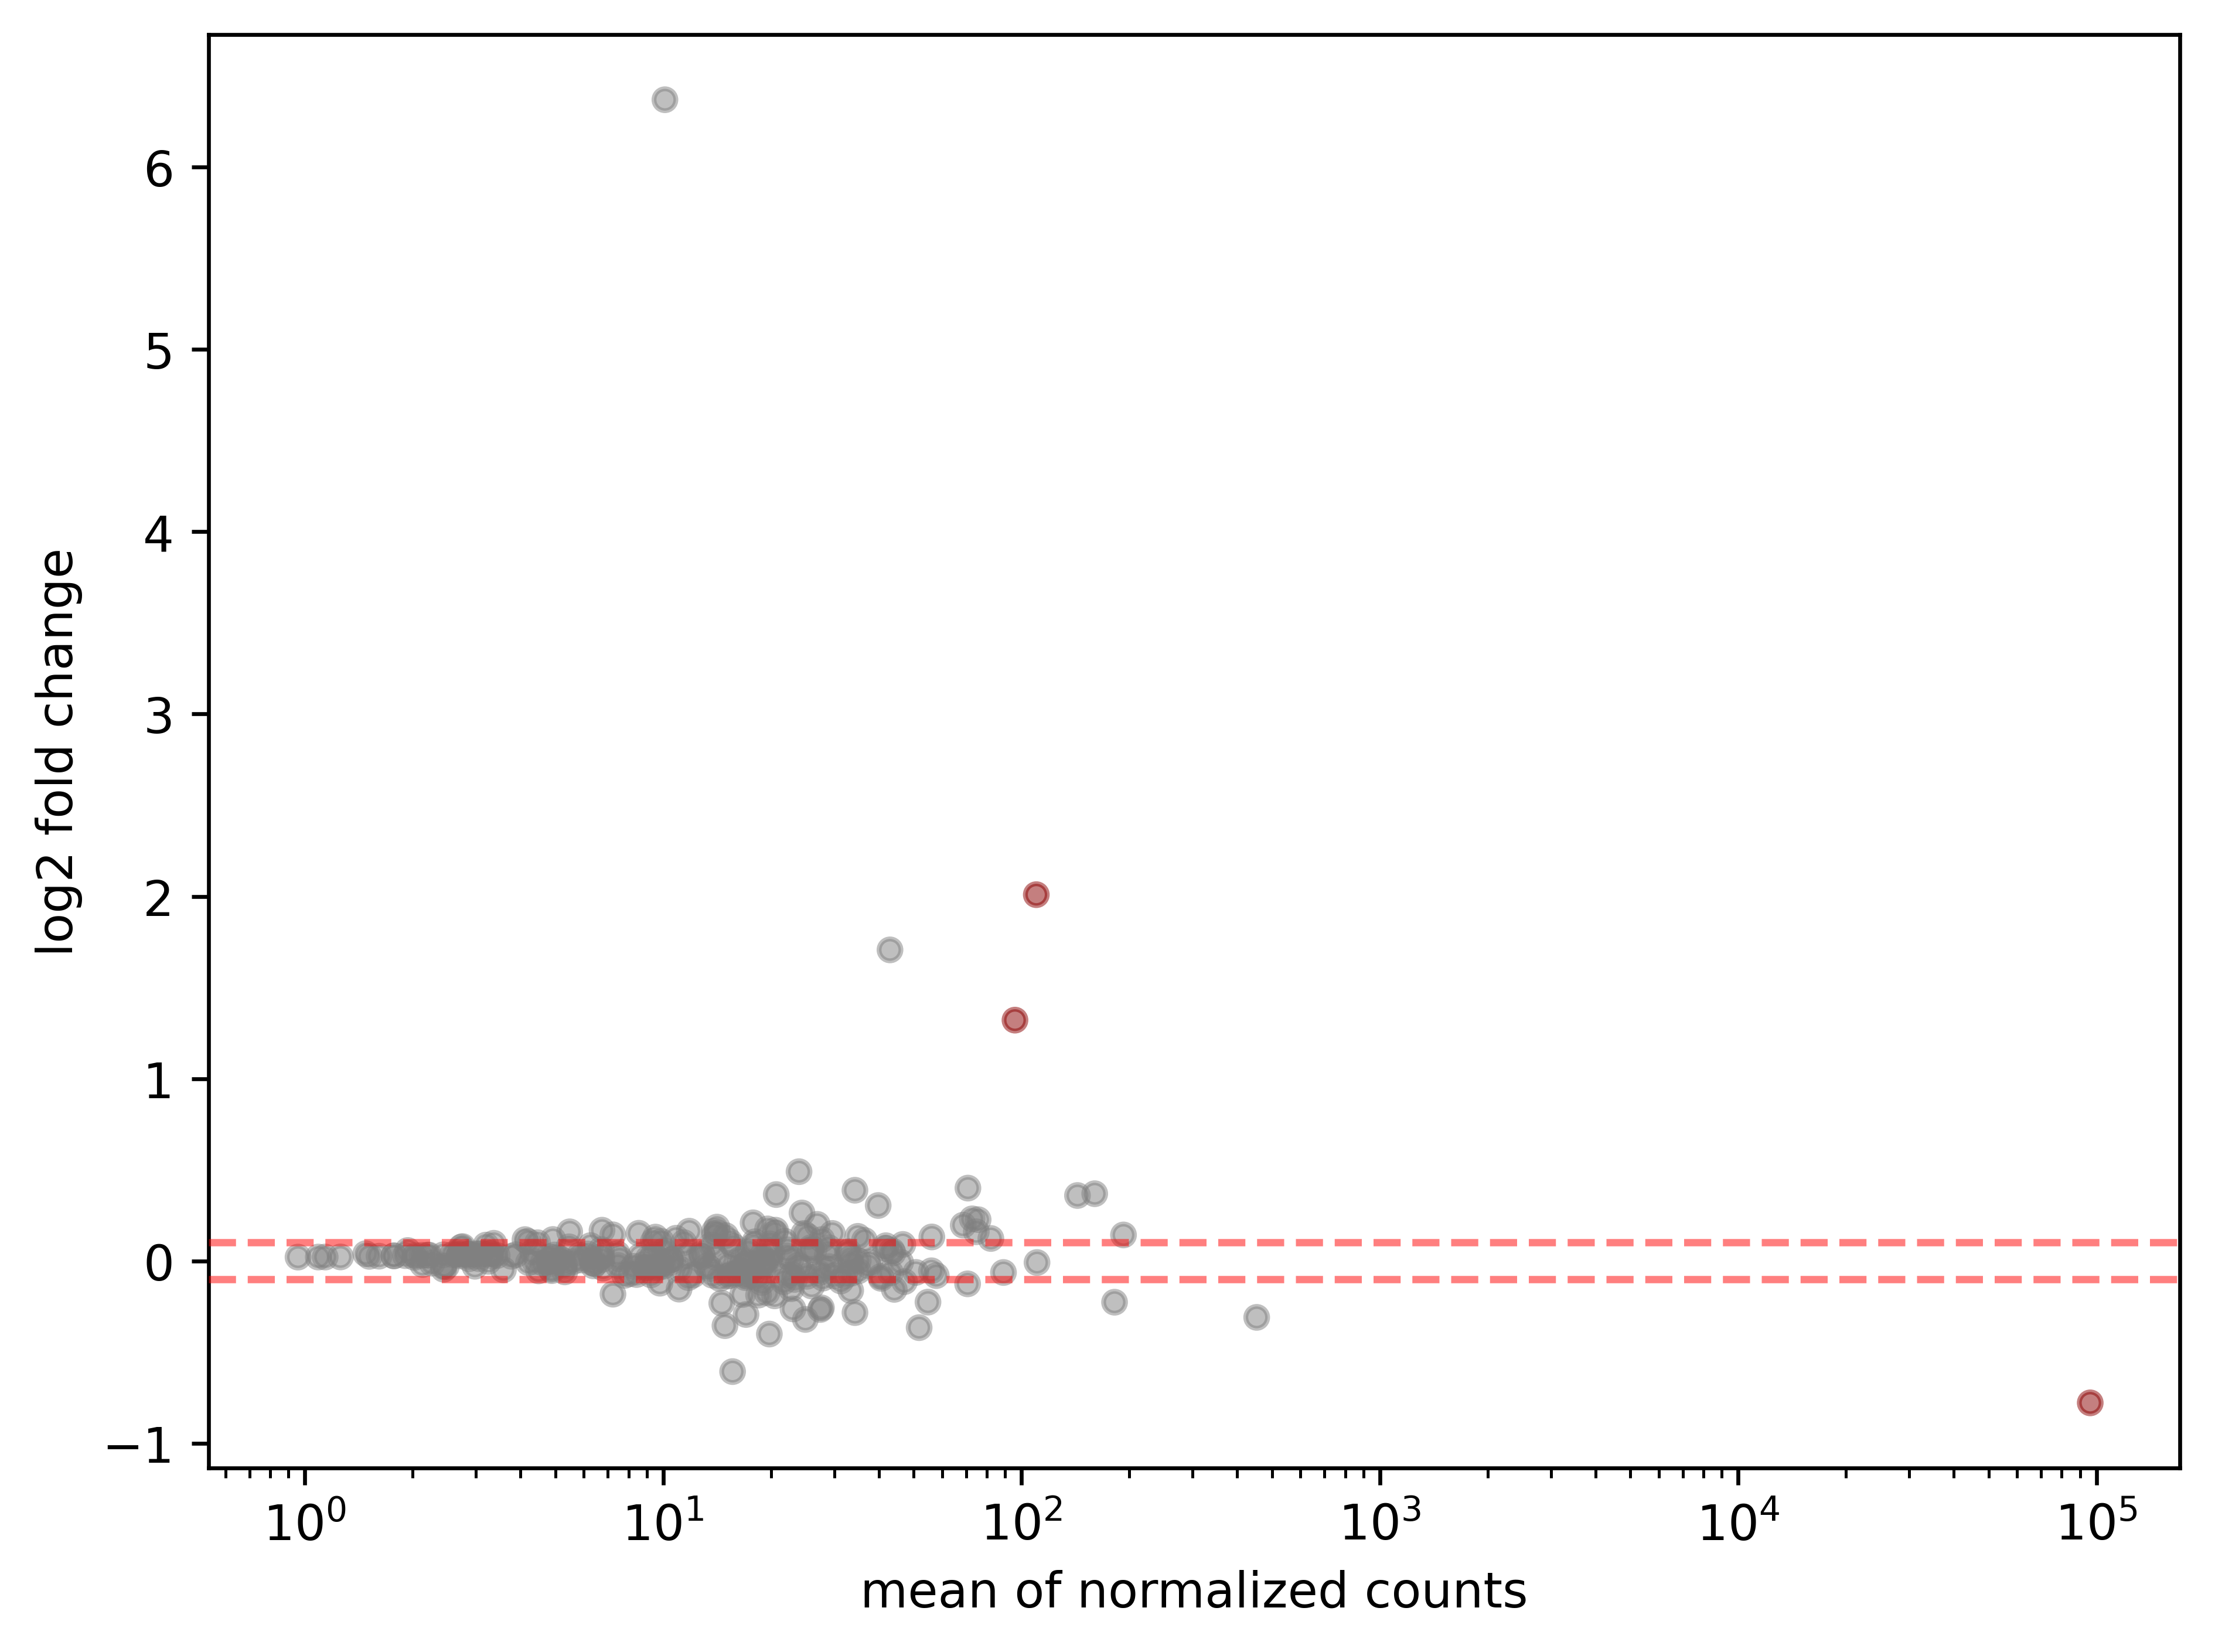

In [17]:
stat_res.plot_MA(s=20)

### Visualize 

In [18]:
results_df = stat_res.results_df
results_df = results_df[['log2FoldChange','padj']].dropna()
negative_log = np.log10(list(results_df["padj"])) * -10
results_df["-10 * log(pvalue)"] = negative_log

In [19]:
results_df

,log2FoldChange,padj,-10 * log(pvalue)
edits,,,
wt,-0.779075,1.060645e-23,229.744298
272G>A,-0.029174,1.000000e+00,-0.000000
271G>A,-0.355623,6.242705e-01,2.046272
269G>A,-0.046359,9.832704e-01,0.073270
265G>A,-0.084177,9.592042e-01,0.180889
...,...,...,...
"229C>T,233C>T",0.039407,7.121982e-01,1.473991
"192G>A,193G>A,200G>A,201G>A,202G>A",0.041111,7.121982e-01,1.473991
"154G>A,161G>A,163G>A",-0.021947,9.832704e-01,0.073270


In [20]:
def contains_edit_special(edit, edit2):
    colors = []
    sizes = []
    
    subset_df = results_df.copy()
    
    for index, row in subset_df.iterrows():
        if len(set(edit).intersection(set(index.split(",")))) > 0:
            colors.append("#00AEEF")
            sizes.append(50)
        elif len(set(edit2).intersection(set(index.split(",")))) > 0:
            colors.append("#EC008C")
            sizes.append(50)
        else:
            colors.append("gray")
            sizes.append(50)
            subset_df.drop(index, inplace=True)
    
    # Create the plot
    plt.figure(figsize=(8, 5))
    
    # Scatter plot
    plt.scatter(results_df['log2FoldChange'] * -1, 
                results_df['-10 * log(pvalue)'],
                c=colors, s=sizes, alpha=0.4)
    
    # Set x-axis to log2 scale
    plt.xscale('symlog', base=2)
    
    # Set axis labels and title
    plt.xlabel("Log2 Fold Change [CD19+ vs CD19-]", fontsize=14)
    plt.ylabel("-10 * log10(pvalue)", fontsize=14)
    plt.title("Volcano Plot", fontsize=16)
    
    # Set x-axis limits and ticks
    plt.xlim(-10, 10)
    
    # Set y-axis limits
    plt.ylim(0, 30)
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save the figure
    plt.savefig("EvoCDA_allelic_analysis_w_MillipedeHits.svg")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Display the subset dataframe
    display(subset_df)

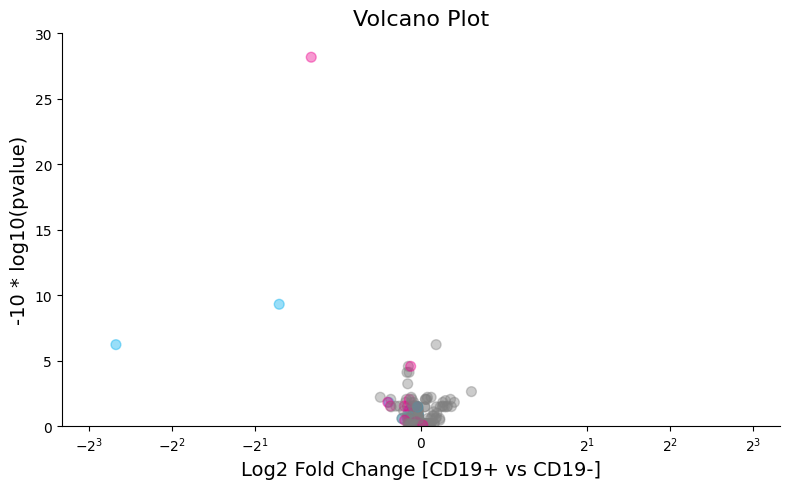

,log2FoldChange,padj,-10 * log(pvalue)
edits,,,
229C>T,0.090075,0.997791,0.009602
"229C>T,232C>T",0.106657,0.703916,1.524789
"229C>T,232C>T,233C>T",0.083752,0.712198,1.473991
227C>T,0.226029,0.875171,0.579070
"227C>T,233C>T",0.107893,0.712198,1.473991
"227C>T,232C>T",0.100209,0.815718,0.884599
"227C>T,229C>T",2.009143,0.000001,59.520669
"227C>T,229C>T,233C>T",0.150457,0.758486,1.200525
"227C>T,229C>T,232C>T",1.706206,0.117293,9.307292


In [21]:
contains_edit_special(["227C>T", "229C>T"], ["154G>A"])